<a href="https://colab.research.google.com/github/mcnica89/Markov-Chains-RL-W25/blob/main/NN_learning_jax_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
from einops import rearrange, reduce
import numpy as np
N_ROWS = 4
N_COLS = 4

# 3 in a liner Helpers

In [2]:
def create_k_in_a_lines(k=3):
    '''Creates a (n_k_in_a_lines, N_ROWS, N_COLS) array with all the possible k in a lines. Slow! Try to only run it once...'''
    #Input: k is the length of the k-in-a-rows to generate
    #Output: Boolean array of shape (n_k_in_a_lines, N_ROWS, N_COLS) array with all possible k_in_a_lines

    k_in_a_line_list = []  # List to store winning line_arrays

    # Horizontal lines
    for r in range(N_ROWS):
        for c in range(N_COLS - k + 1):
            line_array = np.zeros((N_ROWS, N_COLS), dtype=bool)
            line_array[r, c:c+k] = True
            k_in_a_line_list.append(line_array)

    # Vertical lines
    for c in range(N_COLS):
        for r in range(N_ROWS - k + 1):
            line_array = np.zeros((N_ROWS, N_COLS), dtype=bool)
            line_array[r:r+k, c] = True
            k_in_a_line_list.append(line_array)

    # Diagonal (bottom-left to top-right)
    for r in range(N_ROWS - k + 1):
        for c in range(N_COLS - k + 1):
            line_array = np.zeros((N_ROWS, N_COLS), dtype=bool)
            for i in range(k):
                line_array[r + i, c + i] = True
            k_in_a_line_list.append(line_array)

    # Diagonal (top-left to bottom-right)
    for r in range(k - 1, N_ROWS):
        for c in range(N_COLS - k + 1):
            line_array = np.zeros((N_ROWS, N_COLS), dtype=bool)
            for i in range(k):
                line_array[r - i, c + i] = True
            k_in_a_line_list.append(line_array)

    # Stack to Final Shape: (n_k_in_a_lines, N_ROWS, N_COLS)
    stacked_k_in_a_lines = np.stack(k_in_a_line_list)
    return stacked_k_in_a_lines

THREE_IN_A_ROW_MASK = jnp.logical_not(create_k_in_a_lines(k=3))
#Shape (n_3_in_a_rows, N_ROWS, N_COLS) For a 3x3 board n_3_in_a_rows is 8

@jax.jit
def which_three_in_a_line(board_bool):
  '''Inputs a boolean board of shape (...,N_ROWS,N_COLS) and outputs a boolean array of shape (...,n_3_in_a_rows) with which of the possible 3-in-a-lines are there'''
  #Input: board_bool shape (..., N_ROWS, N_COLS) representing a subset of a board
  #Output: shape (..., n_3_in_a_lines) of bool with which 3-in-a-lines are there or not

  #Shape (..., 1, N_ROWS, N_COLS) so it can be broadcasted with the create_k_lines_mask
  broadcastable_board = rearrange(board_bool, '... row col -> ... 1 row col')  #Shape (..., 1, N_ROWS, N_COLS) so it can be broadcast

  line_check_board = jnp.logical_or(THREE_IN_A_ROW_MASK, broadcastable_board )
  #Shape: ( ... , n_3_in_a_lines, N_ROW, N_COLS) by broadcasting
  #..By using a logical_or the board will be ALL trues iff there is a 3 in line


  #reduce out the row and column dimensions by doing an 'all' command
  which_lines = reduce(line_check_board , '... n_line r c -> ... n_line', 'all')

  return which_lines

#Examples:
#board = jnp.array([[1,1,1,0],[1,0,0,0],[1,0,0,0],[0,0,0,0]])
#print(which_three_in_a_line(board))

# Neural Network

In [3]:
N_ROWS = 4
N_COLS = 4
### --- NEURAL NETWORK STUFF ---
input_size = 3*N_ROWS*N_COLS
hidden_size = 64
output_size = 1 #one number for the output!

def init_params(key, input_size, hidden_size, output_size):
    """Initialize network parameters (weights and biases)"""
    # Weights and biases for the first layer (input to hidden)
    key, subkey = jax.random.split(key)
    W1 = jax.random.normal(subkey, (input_size, hidden_size)) * 0.1
    b1 = jnp.zeros(hidden_size)

    # Weights and biases for the second layer (hidden to output)
    key, subkey = jax.random.split(key)
    W2 = jax.random.normal(subkey, (hidden_size, hidden_size)) * 0.1
    b2 = jnp.zeros(hidden_size)

    # Weights and biases for the second layer (hidden to output)
    key, subkey = jax.random.split(key)
    W3 = jax.random.normal(subkey, (hidden_size, output_size)) * 0.1
    b3 = jnp.zeros(output_size)

    return (W1, b1, W2, b2, W3, b3)

@jax.jit
def relu(x):
    """ReLU activation function"""
    return jnp.maximum(0, x)

@jax.jit
def value(params, board):
    """Feedforward function. Returns the logit value for the state"""
    W1, b1, W2, b2, W3, b3 = params
    #one_hot_neg1 = (board == -1)  # Where board is -1
    one_hot_0 = (board == 0)     # Where board is 0
    one_hot_1 = (board == 1)     # Where board is 1
    one_hot_2 = (board == 2)      # Where board is 2

    # Stack along a new axis to form a one-hot encoding (last dimension will be 4)
    #one_hot = jnp.stack([one_hot_neg1, one_hot_1, one_hot_0, one_hot_2], axis=-1)  # Shape (..., N_ROWS, N_COLS, 4)

    one_hot = jnp.stack([one_hot_1, one_hot_0, one_hot_2], axis=-1)  # Shape (..., N_ROWS, N_COLS, 4)

    # Flatten the last three dimensions into a single vector using einops
    x = rearrange(one_hot, "... N_ROWS N_COLS C -> ... (N_ROWS N_COLS C)")

    first = jnp.dot(x, W1) + b1
    hidden = jnp.dot(relu(first),W2) + b2  # Hidden layer with ReLU
    output = 2.0*jax.nn.sigmoid(jnp.dot(relu(hidden),W3) + b3) - 1.0

    #log_probs = jax.nn.log_softmax(output, axis=-1)  # get the log probs
    return rearrange(output, "... 1 -> ...")


In [4]:
key = jax.random.PRNGKey(42)
params = init_params(key, input_size, hidden_size, output_size)
N_BATCH = 3
boards = jax.random.choice(key,jnp.array([0,1,2]),(N_BATCH,N_ROWS, N_COLS))
print(value(params,boards))

[ 0.04973626 -0.03553081  0.09139383]


In [5]:
def loss(params,boards,returns):
  return jnp.mean( (value(params,boards) - returns)**2 )

loss_grad = jax.grad(loss)
my_returns = jnp.ones(N_BATCH)
the_grad = loss_grad(params,boards,my_returns)
print(type(the_grad))

<class 'tuple'>


# Dealing with Tuples

In [6]:
for p in params:
  print(p.shape)

(48, 64)
(64,)
(64, 64)
(64,)
(64, 1)
(1,)


In [7]:
def tupl_minus_python(tupl_a, tupl_b):
  return tuple(map(lambda x, y: x - y, tupl_a, tupl_b))

params_new = tupl_minus_python(params,the_grad)

In [8]:
@jax.jit
def tupl_minus_jax(tupl_a, tupl_b):
  return jax.tree.map(lambda a, b: a - b, tupl_a, tupl_b)

params_new = tupl_minus_jax(params,the_grad)

# Using an Optimizer

In [9]:
#Train AI on a bunch of "finsihed" final state boards
def generate_boards(key, N_samples):
    """Generates N_samples boards of shape (N_ROW, N_COL) filled with 1s and 2s."""
    total_cells = N_ROWS * N_COLS
    half_cells = total_cells // 2  # Assume even number of cells for simplicity

    # Generate random permutations of indices for each board
    keys = jax.random.split(key, N_samples)
    indices = jax.vmap(lambda k: jax.random.permutation(k, total_cells))(keys)

    # Create a template board with half 1s and half 2s
    base_board = jnp.concatenate([jnp.ones(half_cells, dtype=int), 2 * jnp.ones(total_cells - half_cells, dtype=int)])

    # Shuffle this base board according to the random permutations
    boards = jax.vmap(lambda idx: base_board[idx].reshape(N_ROWS, N_COLS))(indices)

    return boards  # Shape: (N_samples, N_ROW, N_COL)

In [10]:
import optax

In [11]:
params = init_params(key, input_size, hidden_size, output_size)
optimizer = optax.adam(learning_rate=1e-2) #rate between 1e-2 and 1e-3 is a good choice!
optimizer_state = optimizer.init(params)

In [12]:
#how to do an update to parameters using the optimizer
my_grad_vals = loss_grad(params, boards, my_returns)
updates, optimizer_state = optimizer.update(my_grad_vals, optimizer_state)
params = optax.apply_updates(params, updates)

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration: 0, RMSE: 0.894


 11%|█         | 106/1000 [00:07<00:22, 39.87it/s]

Iteration: 99, RMSE: 0.508


 20%|██        | 203/1000 [00:10<00:21, 37.51it/s]

Iteration: 199, RMSE: 0.422


 30%|███       | 305/1000 [00:12<00:17, 40.55it/s]

Iteration: 299, RMSE: 0.334


 40%|████      | 405/1000 [00:16<00:17, 34.29it/s]

Iteration: 399, RMSE: 0.298


 50%|█████     | 505/1000 [00:19<00:12, 40.14it/s]

Iteration: 499, RMSE: 0.258


 60%|██████    | 603/1000 [00:21<00:09, 40.05it/s]

Iteration: 599, RMSE: 0.183


 70%|███████   | 705/1000 [00:24<00:07, 40.40it/s]

Iteration: 699, RMSE: 0.183


 80%|████████  | 803/1000 [00:27<00:08, 22.96it/s]

Iteration: 799, RMSE: 0.184


 90%|█████████ | 905/1000 [00:30<00:02, 40.15it/s]

Iteration: 899, RMSE: 0.119


100%|██████████| 1000/1000 [00:33<00:00, 30.21it/s]

Iteration: 999, RMSE: 0.118


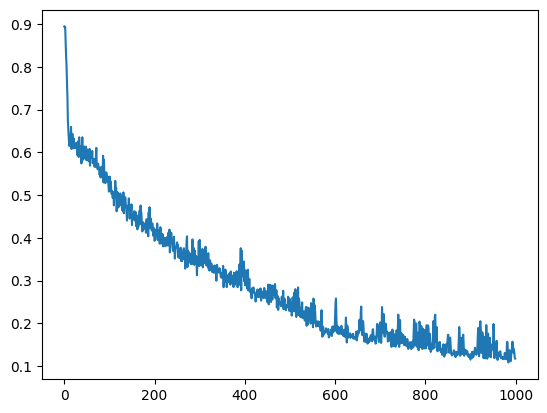

In [14]:
N_BATCH = 1_000
num_iters = 1000
loss = np.zeros(num_iters)
for i in tqdm(range(num_iters)):
  key, subkey = jax.random.split(key)
  boards = generate_boards(key, N_BATCH)

  which_victory_points = which_three_in_a_line(boards == 1) - 1*which_three_in_a_line(boards == 2)
  net_victory_points = reduce(which_victory_points, '... n_line -> ...', 'sum')
  returns = jnp.sign(net_victory_points)

  RMSE = jnp.sqrt(jnp.mean((value(params, boards) - returns)**2))
  loss[i] = RMSE
  if i==0 or (i+1) % (num_iters // 10) == 0:
    print(f"Iteration: {i}, RMSE: {RMSE:.3f}")

  my_grad_vals = loss_grad(params, boards, returns)
  updates, optimizer_state = optimizer.update(my_grad_vals, optimizer_state)
  params = optax.apply_updates(params, updates)

plt.plot(loss)